In [45]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import japanize_matplotlib
import seaborn as sns
## scikit-learnライブラリ
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

#　３_肝疾患判定
- 肝臓の病気は、体に明らかな異変が出てきた時には機能障害が既に進行してしまっていることも多いため、健康診断などの機会に問題（疾患リスク）を事前検知しておくことが大切です。
- そこで今回は、比較的身近な健康診断（血液検査）のデータを使って、肝疾患の有無を判定するモデルの構築にチャレンジ

## データ

|カラム|ヘッダ名称|データ型|説明|
|:----|:----|:----|:----|
|0|id|int|インデックスとして使用|
|1|Age|int|年齢|
|2|Gender|char|性別|
|3|T_Bil|float|検査項目1： 総ビリルビン (Total Bilirubin)|
|4|D_Bil|float|検査項目2： 直接ビリルビン (Direct Bilirubin)|
|5|ALP|float|検査項目3： アルカリフォスファター ゼ (Alkaline Phosphotase)|
|6|ALT_GPT|float|検査項目4： アラニンアミノトランスフェラーゼ (Alanine Transaminase)|
|7|AST_GOT|float|検査項目5： アスパラギン酸アミノトランスフェラーゼ (Aspartate Aminotransferase)|
|8|TP|float|検査項目6： 総タンパク (Total Protiens)|
|9|Alb|float|検査項目7： アルブミン (Albumin)|
|10|AG_ratio|float|検査項目8： アルブミン/グロブリン比|
|11|disease|int|肝疾患の有無（0:無, 1:有）|

## 特徴量アドバイス
|特徴量|計算式|意味|
|:----|:----|:----|
|AST/ALT比|AST_GOT / ALT_GPT|肝疾患の進行度を示す指標|
|ビリルビン比|D_Bil / T_Bil|胆汁うっ滞と肝細胞障害の判別|
|ALP/ALT比|ALP / ALT_GPT|胆汁うっ滞か肝細胞障害かを判別|
|Alb/TP比|Alb / TP|肝機能低下の指標|
|AG_ratio（対数変換）|log(AG_ratio + 1e-5)|正規化による安定性向上|
|性別ごとのAST補正|AST_GOT * (Gender == 'Male') など|性別ごとの肝疾患リスク補正|
|年齢グループ|Young (≤30), Middle (30-50), Old (>50)|肝疾患リスクを年齢層で分類|
|Gender_encoded|1: Male, 0: Female|数値化して学習しやすく|




In [2]:
# データの読み込み
df = pd.read_csv('./data/train.csv')
df

,id,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
0,0,60,Male,2.9,1.3,170.9,42.1,37.1,5.5,2.9,1.01,1
1,1,28,Female,0.7,0.1,158.8,26.0,23.9,6.4,3.7,1.36,0
2,2,60,Male,23.1,12.5,962.0,53.0,40.9,6.8,3.3,0.96,1
3,3,20,Male,1.0,0.5,415.9,33.9,39.0,7.0,3.8,1.31,0
4,4,44,Female,0.6,0.3,152.9,40.9,42.0,4.5,2.1,1.04,0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,886,31,Male,0.7,0.3,164.2,30.0,29.0,6.2,3.0,1.07,0
887,887,57,Female,1.0,0.3,130.1,23.9,25.0,6.9,4.1,1.28,1
888,888,54,Female,23.5,12.7,574.0,43.1,47.0,7.2,3.4,0.84,1
889,889,24,Male,1.2,0.4,130.0,23.2,42.0,8.1,3.9,0.87,1


In [3]:
#infoメソッドを使い、各列のデータ型を確認してみましょう
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        891 non-null    int64  
 1   Age       891 non-null    int64  
 2   Gender    891 non-null    object 
 3   T_Bil     891 non-null    float64
 4   D_Bil     891 non-null    float64
 5   ALP       891 non-null    float64
 6   ALT_GPT   891 non-null    float64
 7   AST_GOT   891 non-null    float64
 8   TP        891 non-null    float64
 9   Alb       891 non-null    float64
 10  AG_ratio  887 non-null    float64
 11  disease   891 non-null    int64  
dtypes: float64(8), int64(3), object(1)
memory usage: 83.7+ KB


In [4]:
#データフレームdfの欠損値の数を確認
df.isnull().sum()

id          0
Age         0
Gender      0
T_Bil       0
D_Bil       0
ALP         0
ALT_GPT     0
AST_GOT     0
TP          0
Alb         0
AG_ratio    4
disease     0
dtype: int64

In [5]:
## AG_ratioの欠損値の補完
# 欠損値の補完（AG_ratioの欠損値を、Alb/(TP-Alb)の計算結果で埋める）
df['AG_ratio'] = df['AG_ratio'].fillna(df['Alb']/(df['TP']-df['Alb']))

In [6]:
df.isnull().sum()

id          0
Age         0
Gender      0
T_Bil       0
D_Bil       0
ALP         0
ALT_GPT     0
AST_GOT     0
TP          0
Alb         0
AG_ratio    0
disease     0
dtype: int64

In [7]:
# Gender列を含む基本統計量の表示
df.describe(include='all')

,id,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
count,891.000000,891.000000,891,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
unique,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,684,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,445.000000,43.340067,NaN,2.807856,1.256790,268.607071,63.770146,81.336139,6.537823,3.230752,0.998036,0.483726
std,257.353842,16.647096,NaN,4.922115,2.578286,226.134887,154.295258,175.539331,1.030673,0.748239,0.302349,0.500016
min,0.000000,3.000000,NaN,0.400000,0.100000,63.000000,9.900000,10.100000,2.600000,0.900000,0.310000,0.000000
25%,222.500000,31.000000,NaN,0.800000,0.200000,170.450000,21.900000,22.900000,5.900000,2.700000,0.810000,0.000000
50%,445.000000,44.000000,NaN,1.100000,0.400000,198.000000,30.000000,35.000000,6.600000,3.200000,0.990000,0.000000
75%,667.500000,57.000000,NaN,2.100000,0.900000,279.000000,51.400000,68.000000,7.300000,3.800000,1.168333,1.000000


In [8]:
# カテゴリ変数の列名をリストで指定
col_categoric = ["Gender", "disease"]
#数量変数のデータフレームを作成し
df_numeric = df.drop(col_categoric, axis=1).copy()
#カテゴリ変数のデータフレームを作成
df_categoric = df[col_categoric].copy()

In [9]:
# 性別のカテゴリ数を確認
df_categoric["Gender"].value_counts()

Gender
Male      684
Female    207
Name: count, dtype: int64

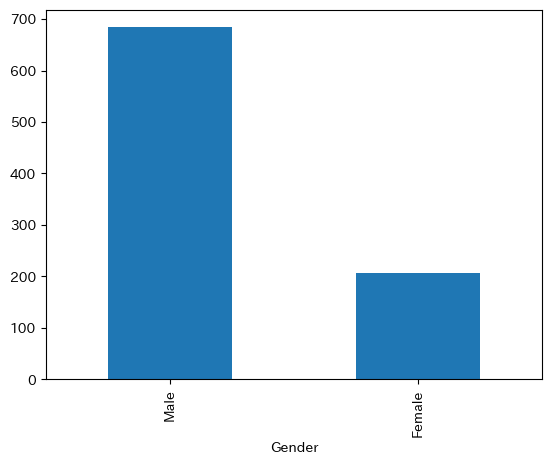

In [12]:
#性別のデータ数を取得
counts_disease = df_categoric["Gender"].value_counts()
#棒グラフによる可視化
counts_disease.plot(kind='bar')
plt.show()

In [10]:
# 疾患有無のカテゴリ数を確認
df_categoric["disease"].value_counts()

disease
0    460
1    431
Name: count, dtype: int64

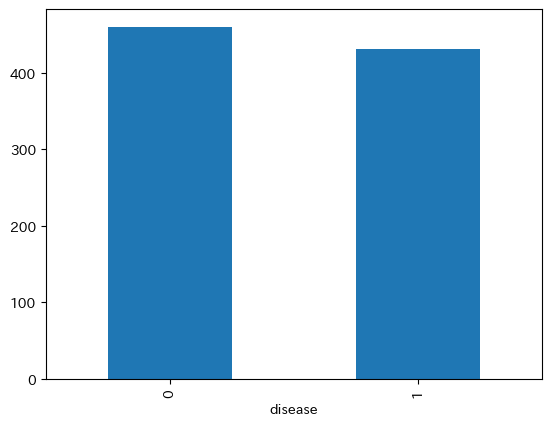

In [ ]:
#diseaseのデータ数を取得
counts_disease = df_categoric["disease"].value_counts()
#棒グラフによる可視化
counts_disease.plot(kind='bar')
plt.show()

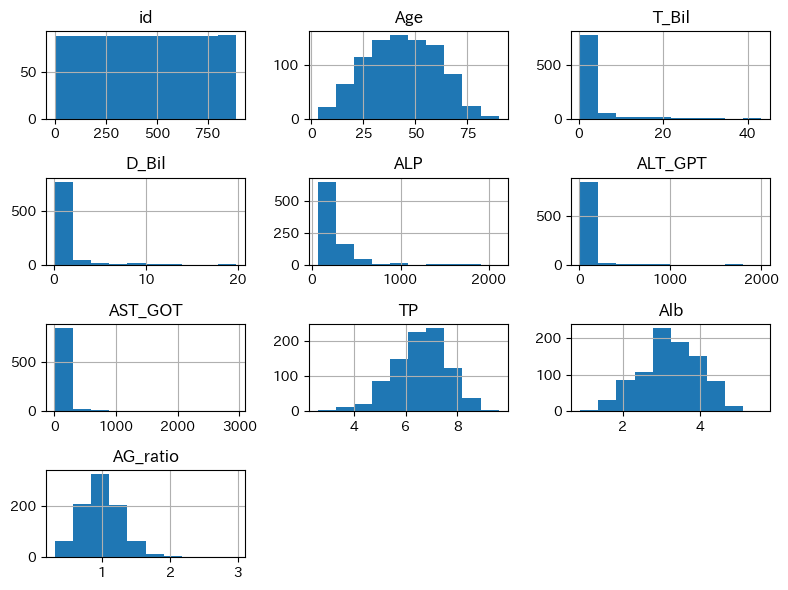

In [13]:
#数量変数のヒストグラムを表示(※figsizeオプションはグラフのサイズを指定）
df_numeric.hist(figsize=(8, 6))
# グラフのラベルが重ならないようにレイアウトを自動調整
plt.tight_layout()
plt.show()

In [ ]:
# df_categoric内の"disease"列と、df_numericの列を横結合する
df_tmp = pd.concat([df_categoric["disease"], df_numeric], axis=1)
#不要な列の削除
df_tmp.drop(columns=["id"], inplace=True)
df_tmp

,disease,Age,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio
0,1,60,2.9,1.3,170.9,42.1,37.1,5.5,2.9,1.01
1,0,28,0.7,0.1,158.8,26.0,23.9,6.4,3.7,1.36
2,1,60,23.1,12.5,962.0,53.0,40.9,6.8,3.3,0.96
3,0,20,1.0,0.5,415.9,33.9,39.0,7.0,3.8,1.31
4,0,44,0.6,0.3,152.9,40.9,42.0,4.5,2.1,1.04
...,...,...,...,...,...,...,...,...,...,...
886,0,31,0.7,0.3,164.2,30.0,29.0,6.2,3.0,1.07
887,1,57,1.0,0.3,130.1,23.9,25.0,6.9,4.1,1.28
888,1,54,23.5,12.7,574.0,43.1,47.0,7.2,3.4,0.84
889,1,24,1.2,0.4,130.0,23.2,42.0,8.1,3.9,0.87


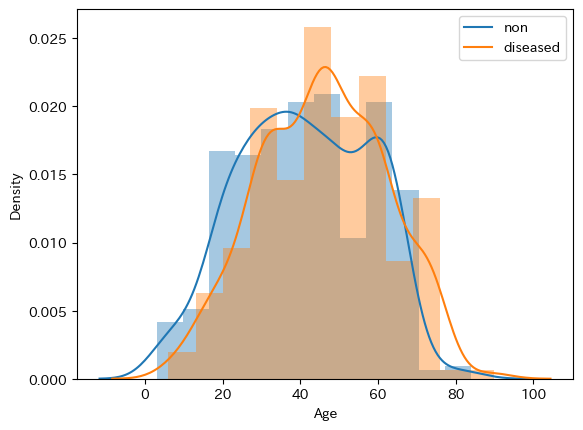

In [16]:
# diseaseの値に応じた"Age"データの抽出
df_Age_non=df_tmp.query("disease==0")["Age"]
df_Age_diseased=df_tmp.query("disease==1")["Age"]
# 2つのデータフレームのヒストグラムを同時に表示
sns.distplot(df_Age_non)
sns.distplot(df_Age_diseased)
# 凡例の表示
plt.legend(labels=["non", "diseased"], loc='upper right')
plt.show()

In [18]:
df_numeric.columns

Index(['id', 'Age', 'T_Bil', 'D_Bil', 'ALP', 'ALT_GPT', 'AST_GOT', 'TP', 'Alb',
       'AG_ratio'],
      dtype='object')

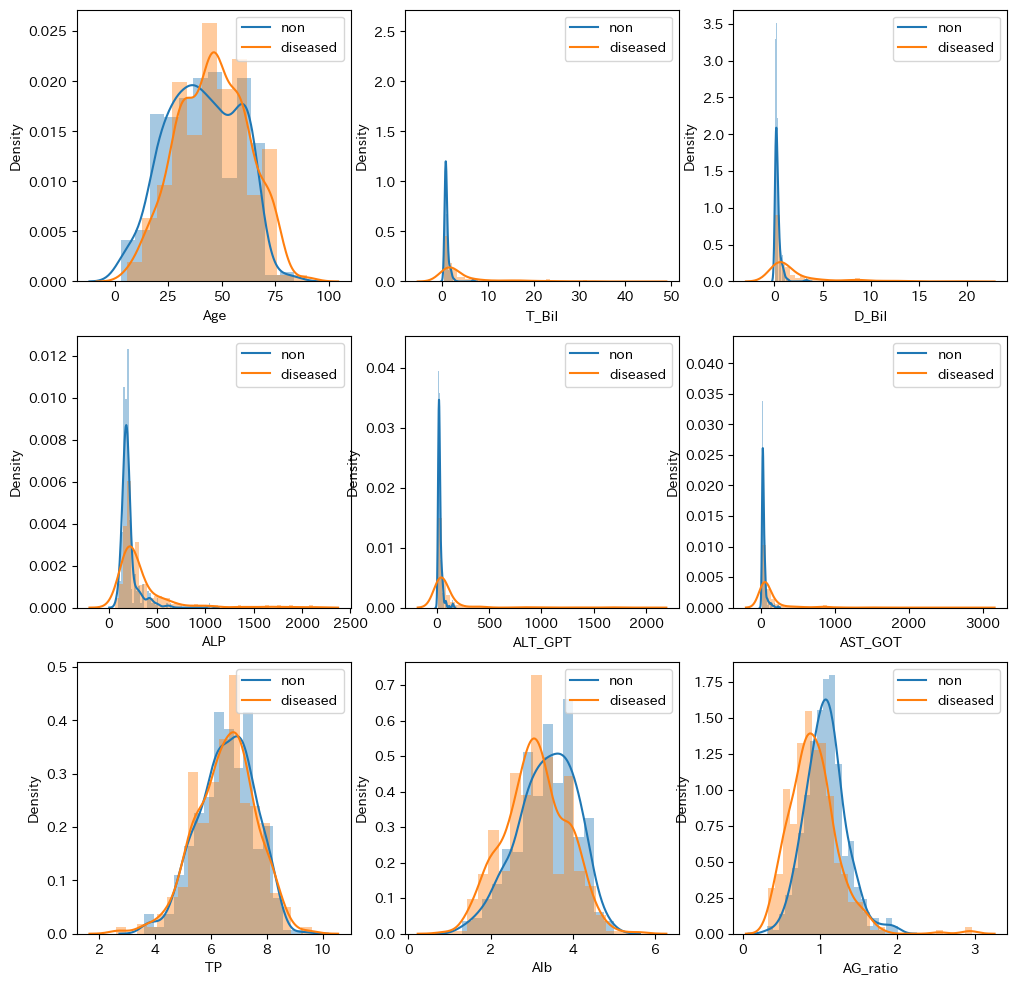

In [19]:
#不要な列の削除
df_numeric.drop(columns=["id"], inplace=True)
# 各カラムと疾患の有無の関係を可視化
plt.figure(figsize=(12, 12))
for ncol, colname in enumerate(df_numeric.columns):
    plt.subplot(3, 3, ncol+1)
    sns.distplot(df_tmp.query("disease==0")[colname])
    sns.distplot(df_tmp.query("disease==1")[colname])
    plt.legend(labels=["non", "diseased"], loc='upper right')
plt.show()

In [21]:
#相関係数行列の算出
df_tmp.corr()

,disease,Age,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio
disease,1.000000,0.144898,0.373955,0.366597,0.274803,0.218902,0.259385,-0.016355,-0.187262,-0.253613
Age,0.144898,1.000000,0.023838,0.022956,0.043923,-0.068371,-0.043663,-0.211715,-0.261470,-0.129721
T_Bil,0.373955,0.023838,1.000000,0.992112,0.256488,0.256965,0.355203,-0.014836,-0.230144,-0.255273
D_Bil,0.366597,0.022956,0.992112,1.000000,0.254928,0.236076,0.328497,-0.014602,-0.224510,-0.246936
ALP,0.274803,0.043923,0.256488,0.254928,1.000000,0.096297,0.116894,-0.023761,-0.154299,-0.192997
ALT_GPT,0.218902,-0.068371,0.256965,0.236076,0.096297,1.000000,0.866955,-0.005689,-0.010086,-0.003419
AST_GOT,0.259385,-0.043663,0.355203,0.328497,0.116894,0.866955,1.000000,-0.007298,-0.068083,-0.063965
TP,-0.016355,-0.211715,-0.014836,-0.014602,-0.023761,-0.005689,-0.007298,1.000000,0.782394,0.154863
Alb,-0.187262,-0.261470,-0.230144,-0.224510,-0.154299,-0.010086,-0.068083,0.782394,1.000000,0.642402
AG_ratio,-0.253613,-0.129721,-0.255273,-0.246936,-0.192997,-0.003419,-0.063965,0.154863,0.642402,1.000000


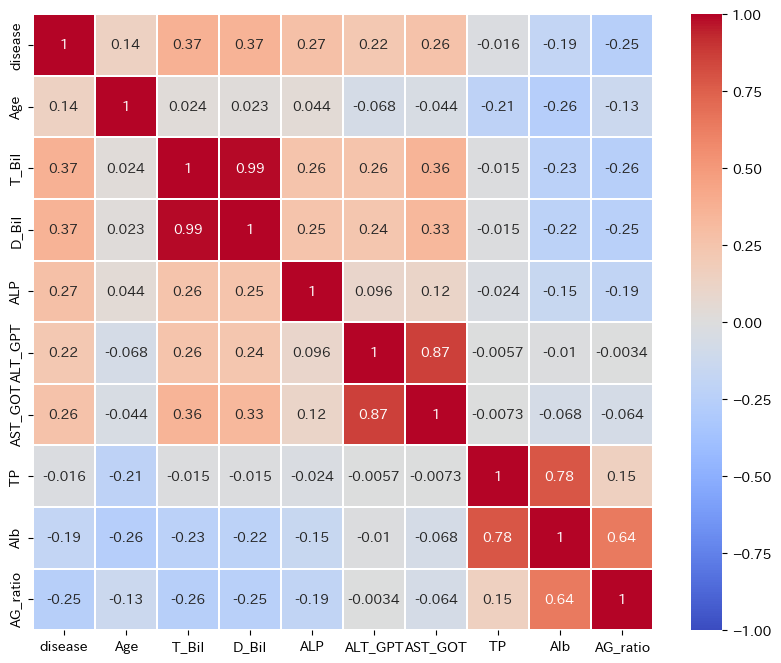

In [ ]:
# 相関係数行列のヒートマップを表示
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), vmin=-1.0, vmax=1.0, annot=True, cmap='coolwarm', linewidths=0.1)
plt.show()

## 特徴量アドバイス
|特徴量|計算式|意味|
|:----|:----|:----|
|AST/ALT比|AST_GOT / ALT_GPT|肝疾患の進行度を示す指標|
|ビリルビン比|D_Bil / T_Bil|胆汁うっ滞と肝細胞障害の判別|
|ALP/ALT比|ALP / ALT_GPT|胆汁うっ滞か肝細胞障害かを判別|
|Alb/TP比|Alb / TP|肝機能低下の指標|

In [27]:
# df_categoric内の"disease"列と、df_numericの列を横結合する
df_tmp = pd.concat([df_categoric["disease"], df_numeric], axis=1)
# AST/ALT比、ビリルビン比、ALP/ALT比、アルブミン/総蛋白比を追加
df_tmp["AST_ALT_ratio"] = df_tmp["AST_GOT"] / df_tmp["ALT_GPT"]
df_tmp["Bilirubin_ratio"] = df_tmp["D_Bil"] / df_tmp["T_Bil"]
df_tmp["ALP_ALT_ratio"] = df_tmp["ALP"] / df_tmp["ALT_GPT"]
df_tmp["Alb_TP_ratio"] = df_tmp["Alb"] / df_tmp["TP"]
df_tmp

,disease,Age,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,AST_ALT_ratio,Bilirubin_ratio,ALP_ALT_ratio,Alb_TP_ratio
0,1,60,2.9,1.3,170.9,42.1,37.1,5.5,2.9,1.01,0.881235,0.448276,4.059382,0.527273
1,0,28,0.7,0.1,158.8,26.0,23.9,6.4,3.7,1.36,0.919231,0.142857,6.107692,0.578125
2,1,60,23.1,12.5,962.0,53.0,40.9,6.8,3.3,0.96,0.771698,0.541126,18.150943,0.485294
3,0,20,1.0,0.5,415.9,33.9,39.0,7.0,3.8,1.31,1.150442,0.500000,12.268437,0.542857
4,0,44,0.6,0.3,152.9,40.9,42.0,4.5,2.1,1.04,1.026895,0.500000,3.738386,0.466667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,31,0.7,0.3,164.2,30.0,29.0,6.2,3.0,1.07,0.966667,0.428571,5.473333,0.483871
887,1,57,1.0,0.3,130.1,23.9,25.0,6.9,4.1,1.28,1.046025,0.300000,5.443515,0.594203
888,1,54,23.5,12.7,574.0,43.1,47.0,7.2,3.4,0.84,1.090487,0.540426,13.317865,0.472222
889,1,24,1.2,0.4,130.0,23.2,42.0,8.1,3.9,0.87,1.810345,0.333333,5.603448,0.481481


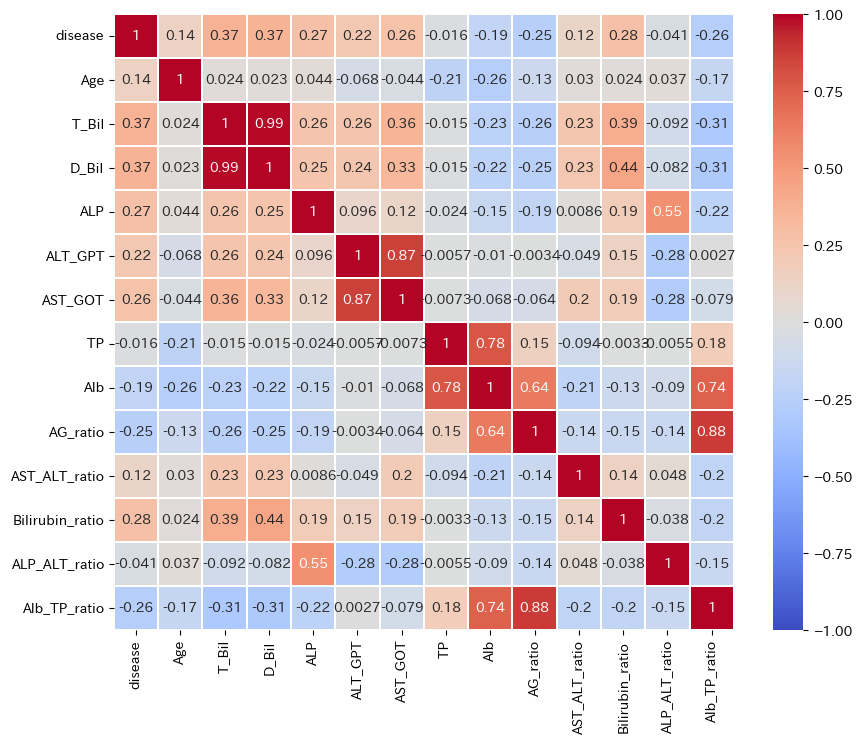

In [26]:
# 相関係数行列のヒートマップを表示
plt.figure(figsize=(10,8))
sns.heatmap(df_tmp.corr(), vmin=-1.0, vmax=1.0, annot=True, cmap='coolwarm', linewidths=0.1)
plt.show()

## 【男女別で見てみる】

In [35]:
# データの読み込み
df = pd.read_csv('./data/train.csv')
df['AG_ratio'] = df['AG_ratio'].fillna(df['Alb']/(df['TP']-df['Alb']))
df["AST_ALT_ratio"] = df["AST_GOT"] / df["ALT_GPT"]
df["Bilirubin_ratio"] = df["D_Bil"] / df["T_Bil"]
df["ALP_ALT_ratio"] = df["ALP"] / df["ALT_GPT"]
df["Alb_TP_ratio"] = df["Alb"] / df["TP"]
#不要な列の削除
df.drop(columns=["id"], inplace=True)
# disease を一番目にし、他のカラムをそのまま並べる
cols = ['disease'] + [col for col in df.columns if col != 'disease']
df = df[cols]
df

,disease,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,AST_ALT_ratio,Bilirubin_ratio,ALP_ALT_ratio,Alb_TP_ratio
0,1,60,Male,2.9,1.3,170.9,42.1,37.1,5.5,2.9,1.01,0.881235,0.448276,4.059382,0.527273
1,0,28,Female,0.7,0.1,158.8,26.0,23.9,6.4,3.7,1.36,0.919231,0.142857,6.107692,0.578125
2,1,60,Male,23.1,12.5,962.0,53.0,40.9,6.8,3.3,0.96,0.771698,0.541126,18.150943,0.485294
3,0,20,Male,1.0,0.5,415.9,33.9,39.0,7.0,3.8,1.31,1.150442,0.500000,12.268437,0.542857
4,0,44,Female,0.6,0.3,152.9,40.9,42.0,4.5,2.1,1.04,1.026895,0.500000,3.738386,0.466667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,31,Male,0.7,0.3,164.2,30.0,29.0,6.2,3.0,1.07,0.966667,0.428571,5.473333,0.483871
887,1,57,Female,1.0,0.3,130.1,23.9,25.0,6.9,4.1,1.28,1.046025,0.300000,5.443515,0.594203
888,1,54,Female,23.5,12.7,574.0,43.1,47.0,7.2,3.4,0.84,1.090487,0.540426,13.317865,0.472222
889,1,24,Male,1.2,0.4,130.0,23.2,42.0,8.1,3.9,0.87,1.810345,0.333333,5.603448,0.481481


In [36]:
len(cols)

15

In [39]:
# 性別ごとにデータを分割
df_male = df[df["Gender"] == "Male"].drop(columns=["Gender"]).copy()
df_female = df[df["Gender"] == "Female"].drop(columns=["Gender"]).copy()

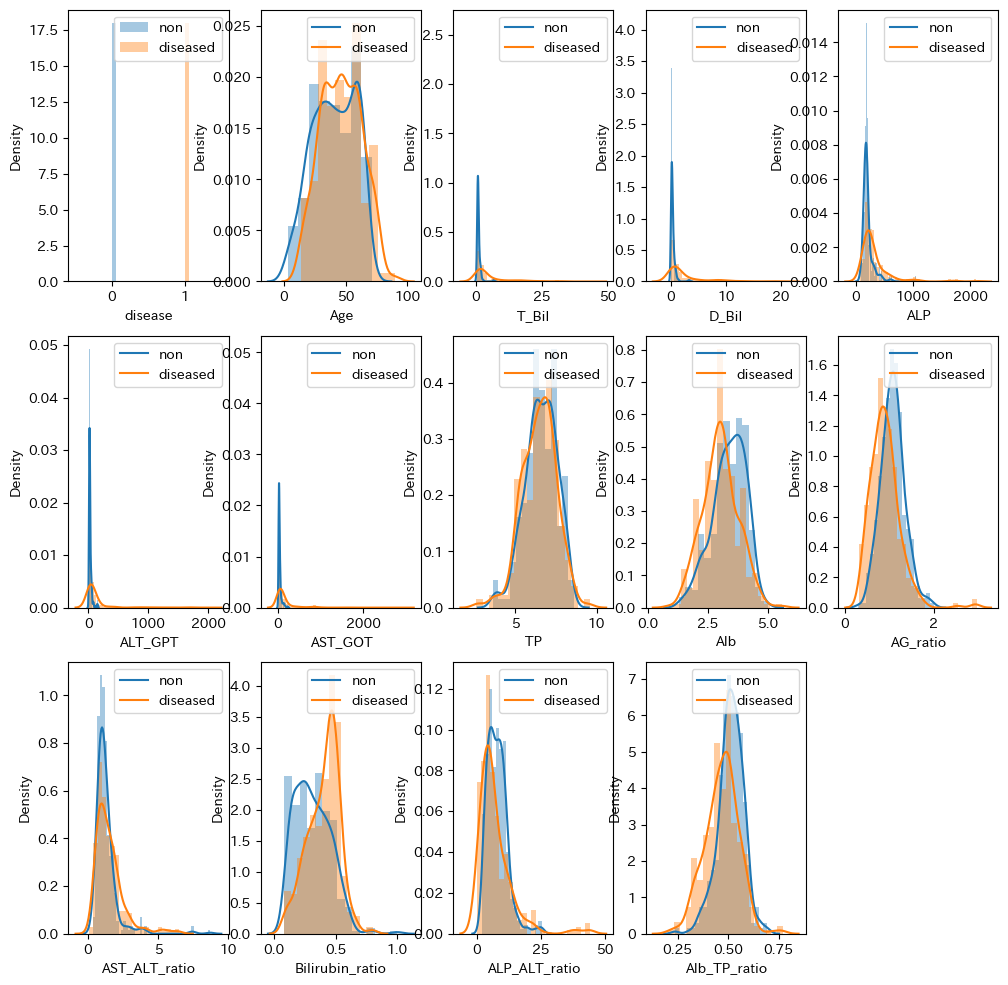

In [40]:
## 男性の
# 各カラムと疾患の有無の関係を可視化
plt.figure(figsize=(12, 12))
for ncol, colname in enumerate(df_male.columns):
    plt.subplot(3, 5, ncol+1)
    sns.distplot(df_male.query("disease==0")[colname])
    sns.distplot(df_male.query("disease==1")[colname])
    plt.legend(labels=["non", "diseased"], loc='upper right')
plt.show()

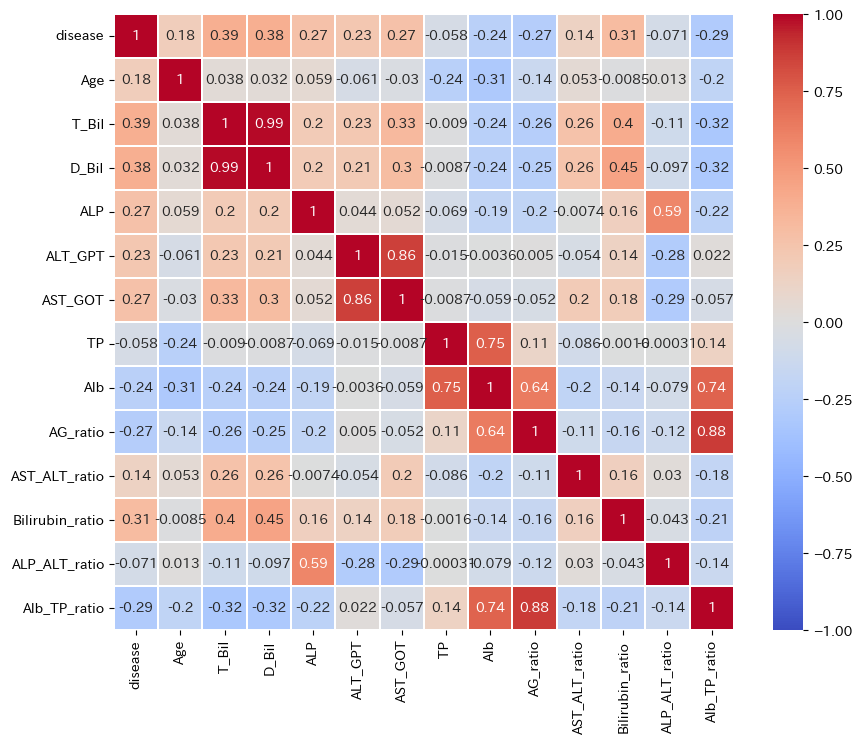

In [41]:
plt.figure(figsize=(10,8))
sns.heatmap(df_male.corr(), vmin=-1.0, vmax=1.0, annot=True, cmap='coolwarm', linewidths=0.1)
plt.show()

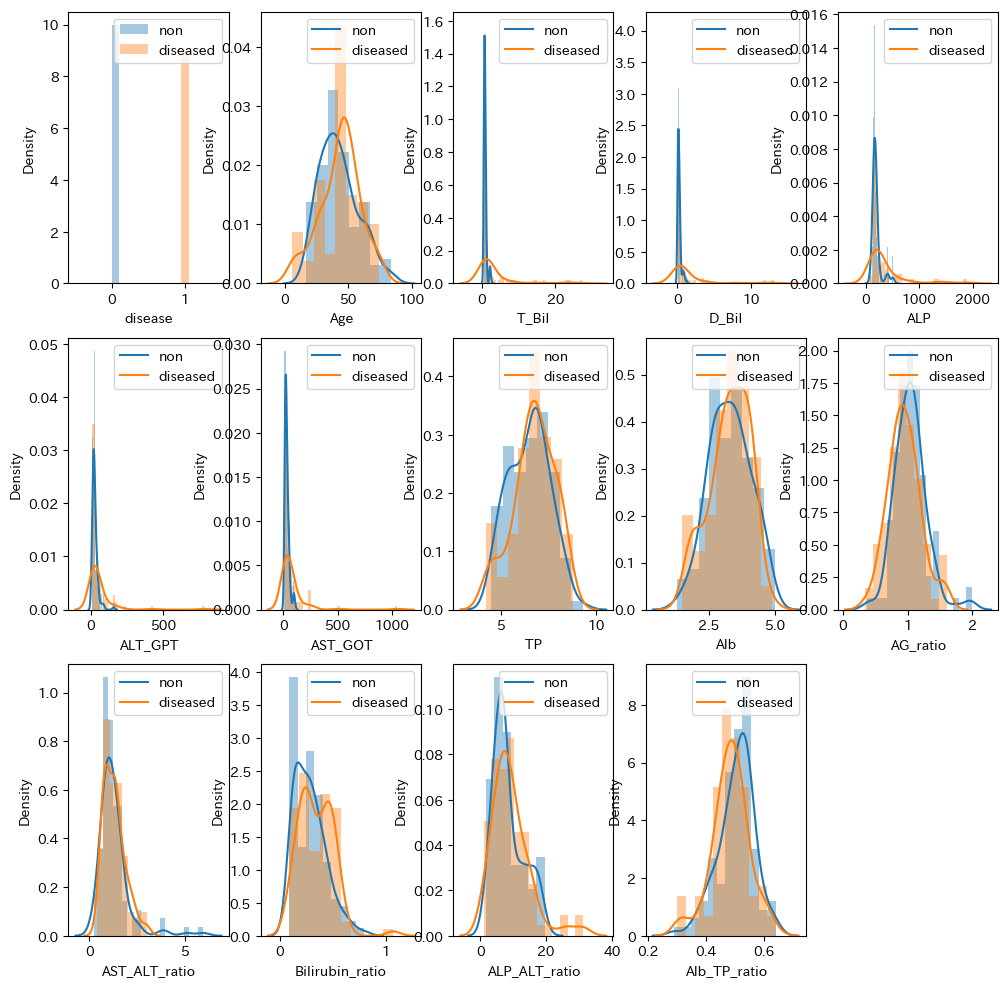

In [42]:
## 女性の
# 各カラムと疾患の有無の関係を可視化
plt.figure(figsize=(12, 12))
for ncol, colname in enumerate(df_female.columns):
    plt.subplot(3, 5, ncol+1)
    sns.distplot(df_female.query("disease==0")[colname])
    sns.distplot(df_female.query("disease==1")[colname])
    plt.legend(labels=["non", "diseased"], loc='upper right')
plt.show()

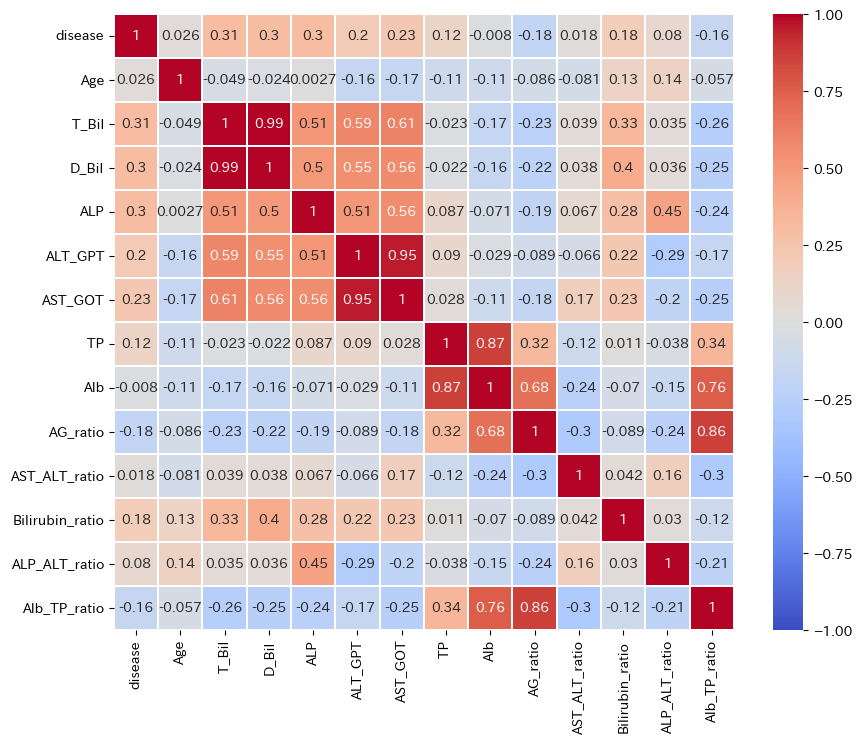

In [43]:
plt.figure(figsize=(10,8))
sns.heatmap(df_female.corr(), vmin=-1.0, vmax=1.0, annot=True, cmap='coolwarm', linewidths=0.1)
plt.show()

## 特徴量を選定

In [49]:
# 逐次特徴選択 (RFE)
# scikit-learn の Recursive Feature Elimination (RFE) を使い、重要な特徴量を選ぶ。
# モデルの定義（ランダムフォレストを例に）
model = RandomForestClassifier()
# RFEで特徴選択（6つの重要特徴を残す）
rfe = RFE(model, n_features_to_select=6)
X_selected = rfe.fit_transform(df_male.drop(columns=['disease']), df_male['disease'])
# 選ばれた特徴
selected_features = df_male.drop(columns=['disease']).columns[rfe.support_]
selected_features

Index(['T_Bil', 'D_Bil', 'ALP', 'ALT_GPT', 'AST_GOT', 'ALP_ALT_ratio'], dtype='object')

In [50]:
model = RandomForestClassifier()
# RFEで特徴選択（6つの重要特徴を残す）
rfe = RFE(model, n_features_to_select=6)
X_selected = rfe.fit_transform(df_female.drop(columns=['disease']), df_female['disease'])
# 選ばれた特徴
selected_features = df_female.drop(columns=['disease']).columns[rfe.support_]
selected_features

Index(['Age', 'T_Bil', 'D_Bil', 'ALP', 'ALT_GPT', 'AST_GOT'], dtype='object')

In [54]:
# 特徴量とターゲットの分割
X_male, y_male = df_male[['T_Bil', 'D_Bil', 'ALP', 'ALT_GPT', 'AST_GOT', 'ALP_ALT_ratio']], df_male["disease"]
X_female, y_female = df_female[['Age', 'T_Bil', 'D_Bil', 'ALP', 'ALT_GPT', 'AST_GOT']], df_female["disease"]

In [55]:
X_male

,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,ALP_ALT_ratio
0,2.9,1.3,170.9,42.1,37.1,4.059382
2,23.1,12.5,962.0,53.0,40.9,18.150943
3,1.0,0.5,415.9,33.9,39.0,12.268437
5,11.1,5.7,699.0,64.0,100.1,10.921875
6,12.4,6.0,514.9,48.1,92.1,10.704782
...,...,...,...,...,...,...
884,2.0,0.8,342.0,168.1,441.0,2.034503
885,0.8,0.1,160.1,42.0,110.0,3.811905
886,0.7,0.3,164.2,30.0,29.0,5.473333
889,1.2,0.4,130.0,23.2,42.0,5.603448


In [56]:
# データの分割（学習用・テスト用）
X_m_train, X_m_test, y_m_train, y_m_test = train_test_split(X_male, y_male, test_size=0.3, random_state=42)
X_f_train, X_f_test, y_f_train, y_f_test = train_test_split(X_female, y_female, test_size=0.3, random_state=42)

In [58]:
# モデルの作成（ランダムフォレストを使用）
model_male = RandomForestClassifier(random_state=42)
model_female = RandomForestClassifier(random_state=42)
# モデルの学習
model_male.fit(X_m_train, y_m_train)
model_female.fit(X_f_train, y_f_train)
# モデルの評価
y_m_pred = model_male.predict(X_m_test)
y_f_pred = model_female.predict(X_f_test)
# 正解率の算出
acc_male = accuracy_score(y_m_test, y_m_pred)
acc_female = accuracy_score(y_f_test, y_f_pred)
print(f"男性モデルの精度: {acc_male:.2f}")
print(f"女性モデルの精度: {acc_female:.2f}")

男性モデルの精度: 0.83
女性モデルの精度: 0.79


In [64]:
# --- 新しいデータに対する予測 ---
def predict_liver_disease(data):
    male_features = ['T_Bil', 'D_Bil', 'ALP', 'ALT_GPT', 'AST_GOT', 'ALP_ALT_ratio']
    female_features = ['Age', 'T_Bil', 'D_Bil', 'ALP', 'ALT_GPT', 'AST_GOT']
    # 男性・女性のデータに分割
    male_data = data[data["Gender"] == "Male"]
    female_data = data[data["Gender"] == "Female"]
    # 予測結果を保存するリスト
    predictions = pd.Series(index=data.index, dtype=int)  # 全データのインデックスを持つ Series
    # 男性モデルの適用
    if not male_data.empty:
        X_male = male_data[male_features]
        predictions.loc[male_data.index] = model_male.predict(X_male)
    # 女性モデルの適用
    if not female_data.empty:
        X_female = female_data[female_features]
        predictions.loc[female_data.index] = model_female.predict(X_female)
    return predictions  # 予測結果を Series で返す


In [65]:
# テストデータ
# データの読み込み
df = pd.read_csv('./data/test.csv')
df['AG_ratio'] = df['AG_ratio'].fillna(df['Alb']/(df['TP']-df['Alb']))
df["AST_ALT_ratio"] = df["AST_GOT"] / df["ALT_GPT"]
df["Bilirubin_ratio"] = df["D_Bil"] / df["T_Bil"]
df["ALP_ALT_ratio"] = df["ALP"] / df["ALT_GPT"]
df["Alb_TP_ratio"] = df["Alb"] / df["TP"]
df

,id,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,AST_ALT_ratio,Bilirubin_ratio,ALP_ALT_ratio,Alb_TP_ratio
0,891,65,Female,0.7,0.2,162.0,24.0,20.0,6.4,3.3,0.93,0.833333,0.285714,6.750000,0.515625
1,892,46,Male,1.2,0.3,265.1,40.0,28.0,7.9,3.8,0.94,0.700000,0.250000,6.627500,0.481013
2,893,26,Male,0.7,0.1,243.1,21.1,22.9,5.3,2.2,0.60,1.085308,0.142857,11.521327,0.415094
3,894,38,Male,3.5,1.7,253.0,80.0,406.0,6.8,3.7,1.33,5.075000,0.485714,3.162500,0.544118
4,895,46,Female,0.7,0.2,236.0,10.1,13.0,6.8,3.0,0.74,1.287129,0.285714,23.366337,0.441176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377,1268,37,Male,1.0,0.4,243.1,50.1,101.0,7.1,3.8,1.18,2.015968,0.400000,4.852295,0.535211
378,1269,46,Male,0.8,0.2,179.1,20.0,57.1,6.5,3.4,1.29,2.855000,0.250000,8.955000,0.523077
379,1270,47,Male,0.8,0.3,326.1,28.8,17.1,8.7,5.6,1.67,0.593750,0.375000,11.322917,0.643678
380,1271,42,Female,0.9,0.1,165.1,27.0,29.0,8.5,4.4,1.05,1.074074,0.111111,6.114815,0.517647


In [68]:
# 予測の実行
prediction = predict_liver_disease(df)
prediction

0      0.0
1      1.0
2      0.0
3      1.0
4      0.0
      ... 
377    1.0
378    0.0
379    0.0
380    0.0
381    0.0
Length: 382, dtype: float64

In [75]:
df = pd.read_csv('./data/test.csv')
df["disease"] = prediction
df[['id','disease']].to_csv('./submission.csv', index=False,header=False)

暫定評価：0.8571035